# **Assignment 3**
Aurélia Haas - *260787990*

---


In [1]:
# Initial Setup
import matplotlib.pyplot as plot
import numpy as np
import cv2
import math
import pandas as pd
import glob
import random
# sklearn
from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# Warnings
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning

from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/My Drive/Colab Notebooks/ECSE 415/Assignment 3/'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---
## **1 - Data**

In [2]:
# Inital Setup
path_data = path + 'Georgia_Tech_Face_Database/*'
subjects_number = 50

# Based on Assignment 3 pdf - Appendix A
# path to csv file
csv_path = path + 'mapping.csv'

# read csv file
df = pd.read_csv(csv_path)

# convert dataframe into two separate lists

# Name - list -- contains name of images
names = list(df["Image"])
# label - list -- contains subject ID / label.
labels = list(df["Label"])

### Convert Images to Gray-Scale and Resize all images to 128x192 Pixel Resolution

In [3]:
# Setup variables
image_dataset = []

# Sort the current database in order to match with labels and names
sorted_database = glob.glob(path_data)
sorted_database.sort()
database = [cv2.imread(image) for image in sorted_database]

for image in database:
  # Convert Image to GrayScale
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  # Resize Image to 128 x 192
  image = cv2.resize(image, (128, 192))

  image_dataset.append(image)

### Prepare the dataset for training and testing

In [4]:
# Setup variables
train_frequency, test_frequency = [], []

# Get random image, set a random state / seed in order to make it easier for the rest of the assignment
image_dataset_shuffled, labels_shuffled, names_shuffled = shuffle(image_dataset, labels, names, random_state = 100)

# Select 80% of Images for train set and the remaining ones for test set
# Set train and test arrays and frequencies
train_length = math.floor(0.8 * len(image_dataset))
test_length = len(image_dataset) - train_length

# Set Images and Labels
train_set = image_dataset_shuffled[ : train_length]
train_labels = labels_shuffled[ : train_length]
train_names = names_shuffled[ : train_length]

test_set = image_dataset_shuffled[train_length : ]
test_labels = labels_shuffled[train_length : ]
test_names = names_shuffled[train_length : ]

# Set Distribution for Training and Testing - 15 color images per subject
# Training Frequency is the total number of images per subject (15) - Testing Freqency as 100% images are divided up in Training (80%) and Testing (20%) Sets
for i in range(1, subjects_number + 1):
  frequency = 0
  for j in range(len(test_labels)):
    if(i < 10 and (("S0" + str(i)) in test_names[j]) and i == test_labels[j]):
      frequency += 1
    elif(i >= 10 and (('S' +str(i)) in test_names[j]) and i == test_labels[j]):
      frequency += 1
  test_frequency.append(frequency)
  train_frequency.append(15 - frequency)
  frequency = 0

### Display total 10 random images from the training set along with their name and label. Plot histogram of the frequency of each image class distribution for both the training set and the testing set

10 Random Images from the Training Set


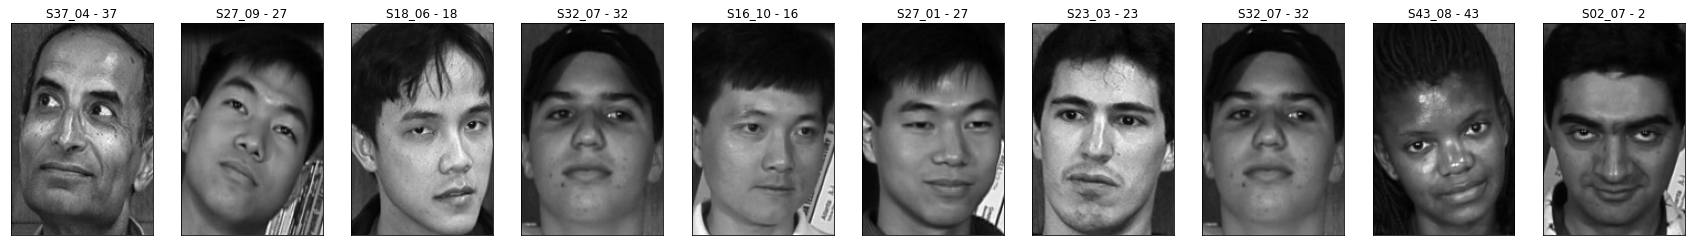

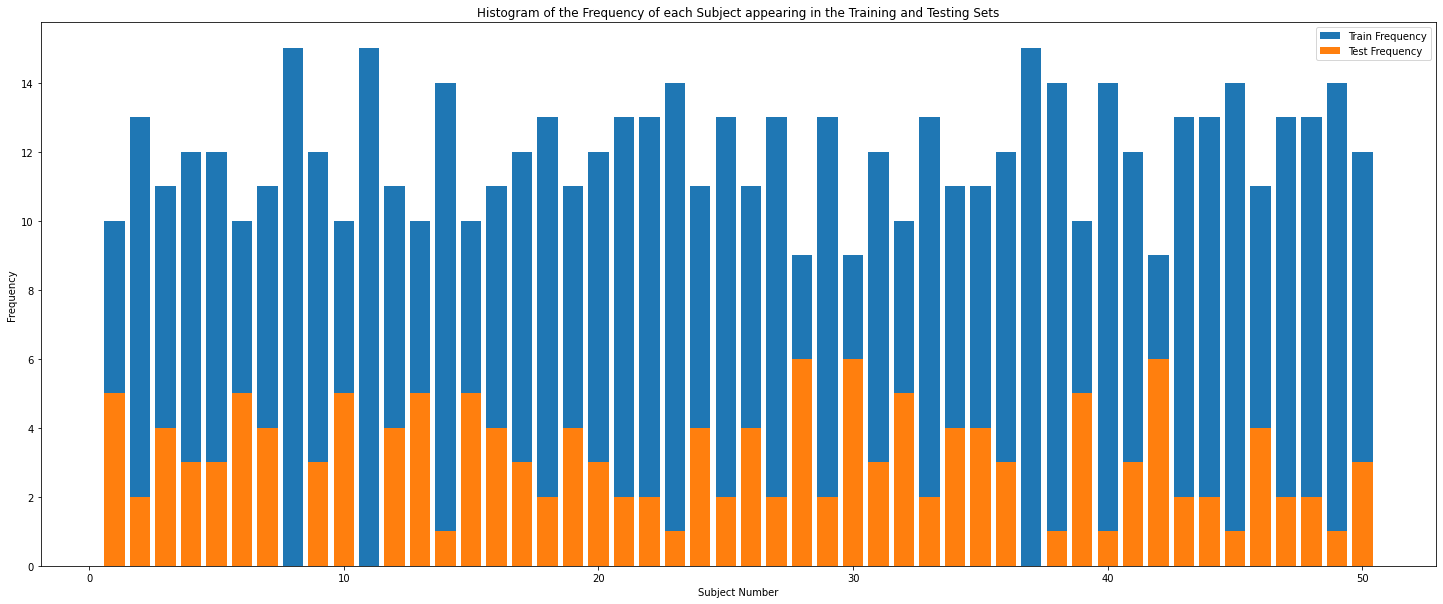

In [5]:
# Display 10 Random Images from the Training Set
figures = plot.figure(figsize =(30, 30))
print("10 Random Images from the Training Set")

for i in range(10):
    random_number = random.randint(0, len(train_set) - 1)
    figures.add_subplot(1, 10, i + 1)
    title = "{} - {}".format(train_names[random_number], train_labels[random_number])
    plot.title("{}" .format(title))
    plot.xticks([])
    plot.yticks([])
    plot.imshow(train_set[random_number], cmap="gray")
plot.show()

print()

# Plot Histogram of the Frequency for each image class distribution for both the Training and Testing sets
plot.figure(figsize = (25, 10))
plot.bar(range(1, len(train_frequency) + 1), train_frequency, label = "Train Frequency")
plot.bar(range(1, len(test_frequency) + 1), test_frequency, label = "Test Frequency")
plot.legend()
plot.xlabel("Subject Number")
plot.ylabel("Frequency")
plot.title("Histogram of the Frequency of each Subject appearing in the Training and Testing Sets")
plot.show()

---
## **2 - Eigenface Representation**


### PCA

In [6]:
# Some of the code below is referred from Tutorial 5 and lecture 8, slide 55

# Based on https://www.askpython.com/python/examples/principal-component-analysis 
def PCA(pca_set):

  # Represent each image in the pca_set as a vector
  vector_database = []
  for image in pca_set:
    flat = np.asarray(image).flatten()
    vector_database.append(flat)
  vector_database = np.transpose(vector_database)

  # Subtract mean face from the vector_dataset
  mean = np.mean(vector_database, axis = 0)
  mean_face = vector_database - mean

  # Calculate the covariance matrix
  covariance_matrix = np.cov(mean_face, rowvar = False)

  # Compute the eigenvalues and eigenvectors of the covariance matrix
  eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

  # Sort the eigenvalues and eigenvectors in decreasing order of variability
  sorted_indices = np.argsort(eigenvalues)[ : : -1]
  sorted_eigenvalues = eigenvalues[sorted_indices]
  sorted_eigenvectors = eigenvectors[ : , sorted_indices]

  return sorted_eigenvalues, sorted_eigenvectors, sorted_indices, mean, mean_face, vector_database

### Plot the fraction of total variance against the number of eigenvectors

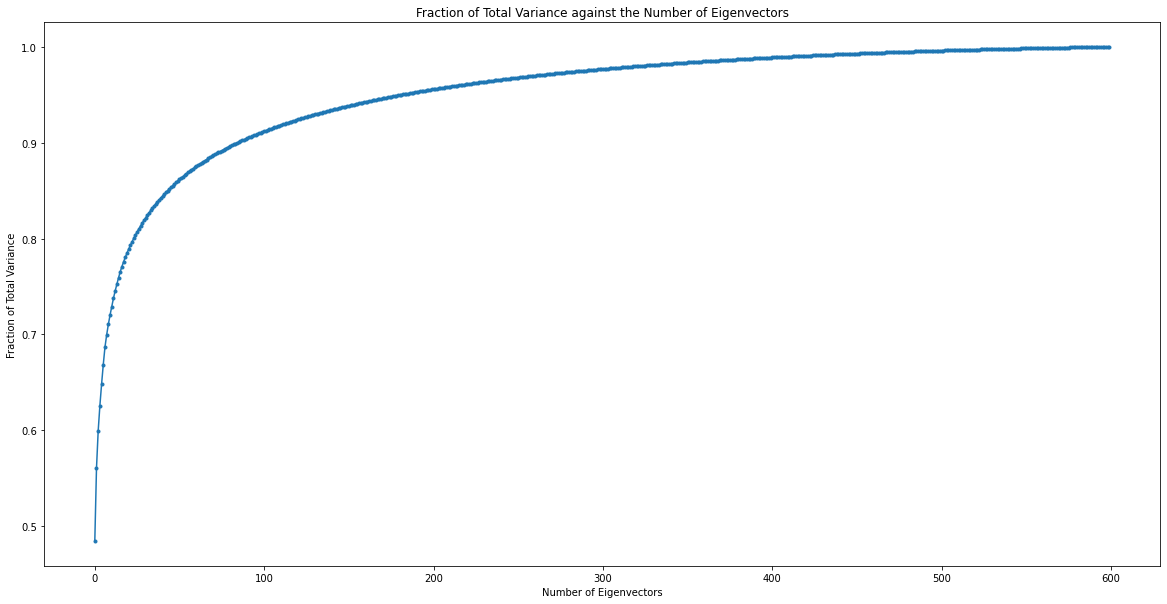

In [7]:
# Call the PCA() function to get the eigenvalues, eigenvectors, indices and mean face of the train_set
eigenvalues, eigenvectors, indices, mean, mean_face, vector_database = PCA(train_set)
total_variance = np.cumsum(eigenvalues) / np.sum(eigenvalues)

# Plot the fraction of total variance against the number of eigenvectors
plot.figure(figsize=(20, 10))

plot.plot(total_variance, '.-')
plot.xlabel("Number of Eigenvectors")
plot.ylabel("Fraction of Total Variance")
plot.title("Fraction of Total Variance against the Number of Eigenvectors")
plot.show()

### Plot the normalized variance (eigenvalues) against the eigenvector index used for computation

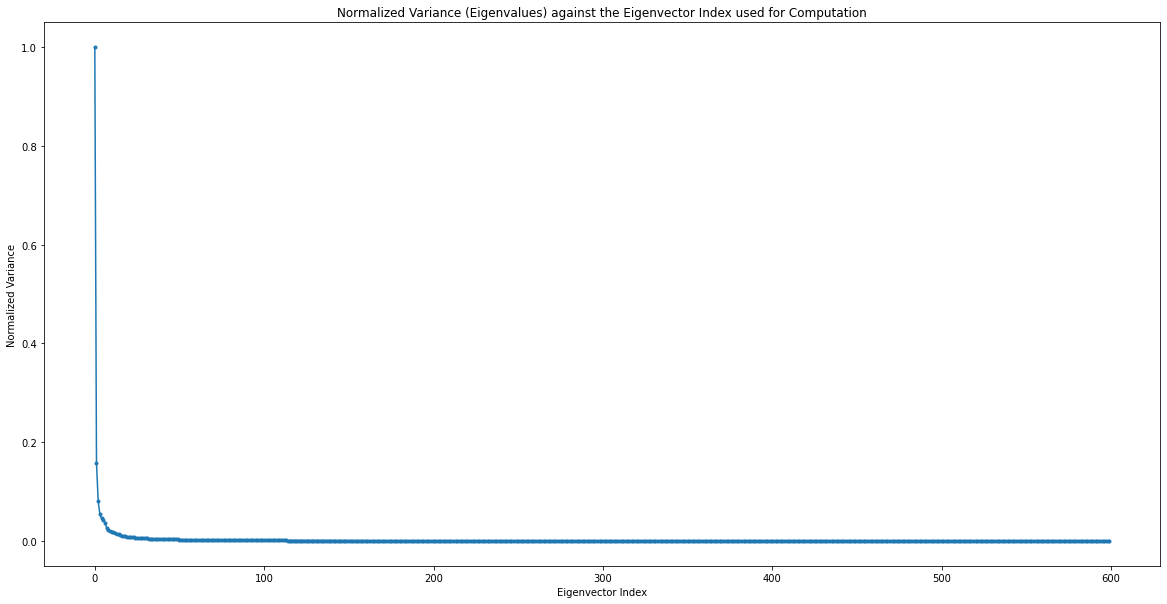

In [8]:
# Use the eigenvalues found when running the PCA() function
normalized_variance = eigenvalues / np.max(eigenvalues)

# Plot the normalized variance (eigenvalues) against the eigenvector index used for computation 
plot.figure(figsize=(20, 10))

plot.plot(normalized_variance, '.-')
plot.xlabel("Eigenvector Index")
plot.ylabel("Normalized Variance")
plot.title("Normalized Variance (Eigenvalues) against the Eigenvector Index used for Computation")
plot.show()

### Do you need all the vectors to represent the data?

No, we do not need all the vectors to represent the data. From the Fraction of Total Variance against the Number of Eigenvectors graph, we can observe that around 100 eigenvectors capture more than 90% of the variance in the training set. <br/>
After reaching 100 eigenvectors, and as the number of eigenvectors are increasing, the rate of change in gradient of the curve gets smaller - the curve is starting to look more and more like a flat curve until it reaches 1 really slowly at around 600 eigenvectors. <br/>
The goal while using the Principal Component Analysis (PCA) is essentially to use vectors that capture most of the variance to represent all the data from the training set. Therefore, in our case, we can conclude that the 100 eigenvectors are sufficient to represent all of the data from the training set.

### Display the first 5 eigenfaces

Displaying the first 5 eigenfaces


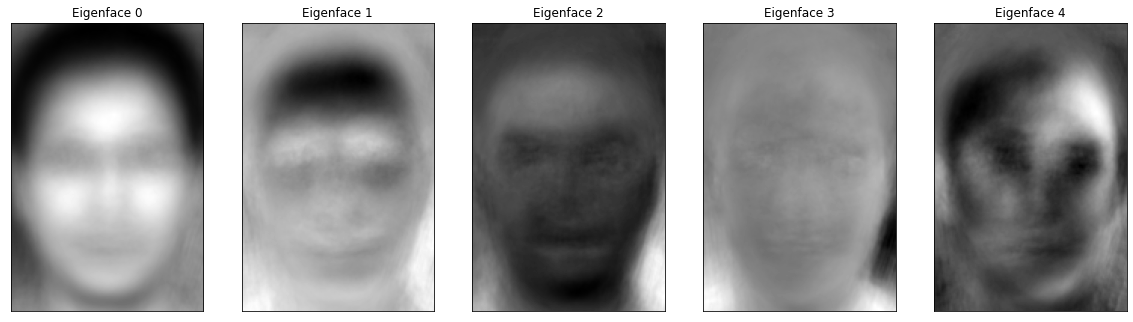

In [9]:
# Displaying the first 5 eigenfaces 
# Use the eigenvectors found when running the PCA() function
eigenfaces = np.dot(eigenvectors.transpose(), mean_face.transpose())

# Display Eigenfaces
figure = plot.figure(figsize = (20, 20))
print("Displaying the first 5 eigenfaces")

for i in range(5):
    eigenface = np.reshape(eigenfaces[i], (192, 128))
    # Plot images
    figure.add_subplot(1, 5, i + 1)
    plot.title("Eigenface {}" .format(i))
    plot.xticks([])
    plot.yticks([])
    plot.imshow(eigenface, cmap="gray")
plot.show()

---
## **3 - Classification**


### For every testing image, find the nearest neighbour (L2 distance)

In [10]:
def get_accuracy(predicted_labels, tested_labels):
  matches = 0
  total_test_images = len(tested_labels)
  for i in range(len(tested_labels)):
    if predicted_labels[i] == tested_labels[i]:
      matches += 1
  accuracy = matches / total_test_images
  return accuracy

In [11]:
# Setup variables
# k set to 100 following the variance results
k = 100

# Represent each image in the train set and test set as a vector
train_set_vector, test_set_vector = [], []

for image in train_set:
  flat = np.asarray(image).flatten()
  train_set_vector.append(flat)

for image in test_set:
  flat = np.asarray(image).flatten()
  test_set_vector.append(flat)


# Accuracy in Pixel Space
# Classify Data using a KNN and Get Accuracy 
neigh = KNeighborsClassifier(n_neighbors = 1)
neigh.fit(train_set_vector, train_labels)
predicted_labels = neigh.predict(test_set_vector)
accuracy = get_accuracy(predicted_labels, test_labels) * 100
print("Accuracy in the High Dimensional Pixel Space is {}%" .format(accuracy))


# Accuracy in Eigen Space 
# Normalize Eigenfaces
eigenfaces /= np.linalg.norm(eigenfaces, axis = 1, keepdims = True)
k_eigenfaces = eigenfaces[ : k]
# Project train set to lower dimensionality
train_data = vector_database
train_projection = np.dot(k_eigenfaces, vector_database).transpose()

# Project test set to lower dimensionality
test_data = np.transpose(test_set_vector)
test_projection = np.dot(k_eigenfaces, test_data).transpose()

# Classify Data using a KNN and Get Accuracy 
neigh = KNeighborsClassifier(n_neighbors = 1)
neigh.fit(train_projection, train_labels)
predicted_labels = neigh.predict(test_projection)
accuracy = get_accuracy(predicted_labels, test_labels) * 100
print("Accuracy in the Eigenspace is {} %" .format(accuracy))

Accuracy in the High Dimensional Pixel Space is 80.0%
Accuracy in the Eigenspace is 72.0 %


### Compare the accuracy values

The accuracy of the KNN classifier in both the high dimensional pixel space and in the eigenspace is quite similar. 
<br/>
The accuracy in both classifier instances is between 70-80%. We can notice that he accuracy is really close to the expected accuracy of 75% when using PCA with 100 components for this experiment. This was confirmed by performing this section of assignment using the PCA implementation from sklearn module to get an idea of the expected results.
A significant difference between the high dimensional pixel space and the eigenspace is not really expected since PCA is designed to contain the majority of the variation between faces in a smaller amount of data 

### Linear SVM Classifier

In [12]:
# To ignore ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

# Based on Tutorial 6
clf = svm.LinearSVC()        
clf.fit(train_projection, train_labels)
predicted_labels = clf.predict(test_projection)
accuracy = get_accuracy(predicted_labels, test_labels) * 100

print("Accuracy using the Linear SVM Classifier is {} %" .format(accuracy))

Accuracy using the Linear SVM Classifier is 66.66666666666666 %


### RBF SVM Classifier

In [13]:
# Based on Tutorial 6
# Non-linear SVM with RBF kernel on the raw data
clf = svm.SVC()
clf.fit(train_projection, train_labels)
predicted_labels = clf.predict(test_projection)
accuracy = get_accuracy(predicted_labels, test_labels) * 100

print("Accuracy using the RBF SVM Classifier is {} %" .format(accuracy))

Accuracy using the RBF SVM Classifier is 74.0 %


### Random Forest Classifier

In [14]:
# Based on Tutorial 6
clf = RandomForestClassifier()
clf.fit(train_projection, train_labels)
predicted_labels = clf.predict(test_projection)
accuracy = get_accuracy(predicted_labels, test_labels) * 100

print("Accuracy using the Random Forest Classifier is {} %" .format(accuracy))

Accuracy using the Random Forest Classifier is 70.0 %


### Compare the accuracy of these classifiers with the nearest neighbour classifier

Accuracy in the High Dimensional Pixel Space is 80.0% <br/>
Accuracy in the Eigenspace is 72.0 % <br/>

Accuracy using the Linear SVM Classifier is 66.66666666666666 % <br/>
Accuracy using the RBF SVM Classifier is 74.0 % <br/>
Accuracy using the Random Forest Classifier is 70 % <br/>
<br/>
By observing the results obtained for each classifier and the nearest neighbour classifier, we can totally see that the latter is the most efficient.
This makes sense since the KNN algorithm is simple and assumes that similar things are near to each other. This algorithm is different from the other classifiers since it does not require any statistical assumption. In addition, KNN is known to be robust to noisy training data and is effective in case of large number of training examples, which is the case here (600 images in the training set).
SVM requires a lot of time for training and is not effective enough for a large number of training examples. 
For Random Forest, it should be a good classifier, as it uses decision trees, but in our case the accuracy is lower for this algorithm.
Nonetheless, all the classifiers have similar accuracies, and if the shuffle was not seed, the accuracies would a bit different.

### Calculate per-class accuracy

In [15]:
# To avoid Warnings
simplefilter("ignore", category=RuntimeWarning)

# Based on https://stackoverflow.com/questions/39770376/scikit-learn-get-accuracy-scores-for-each-class
y_true = test_labels
y_pred = predicted_labels

# Get the confusion matrix
matrix = confusion_matrix(y_true, y_pred)
matrix.diagonal()/matrix.sum(axis=1)

array([0.2       , 0.5       , 0.5       , 1.        , 0.33333333,
       0.6       , 0.25      , 0.        , 0.6       ,        nan,
       1.        , 0.6       , 0.        , 1.        , 0.5       ,
       1.        , 1.        , 0.75      , 0.66666667, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.5       , 0.83333333, 1.        , 0.5       , 0.33333333,
       0.8       , 0.5       , 0.75      , 1.        , 1.        ,
       0.        , 0.8       , 1.        , 0.66666667, 0.83333333,
       0.5       , 1.        , 0.        , 0.75      , 0.5       ,
       0.5       , 1.        , 1.        ])

### Do you see any correlation between per-class accuracy and histograms?

In the confusion matrix, we are comparing, the test labels and the predicted labela We can observe different common things between per-class accuracy and histograms:   

*   When there is no element at all in the testing set for a certain person (i.e., label), and this label is also not predicted, then the accuracy for this label will not appear at all on the per class accuracy (and did not appear on the histogram either). This means that the per-class accuracy might not have 50 elements since one might be missing on both the predicted labels and the test labels
*   When there is no element at all in the testing set for a certain person (i.e., label), but this label is predicted, then in the per-class accuracy, the value will appear as "nan"
* When there is at least an element represented in the testing set for a certain person (i.e., label), but this label is not predicted at all, then the accuracy for this label will be equal to 0
* Otherwise, when there is a match (respectively no match) between the test label and the predicted label, the accuracy of the test label increases (respectively decreases).




---
## **4 - Face Detection**

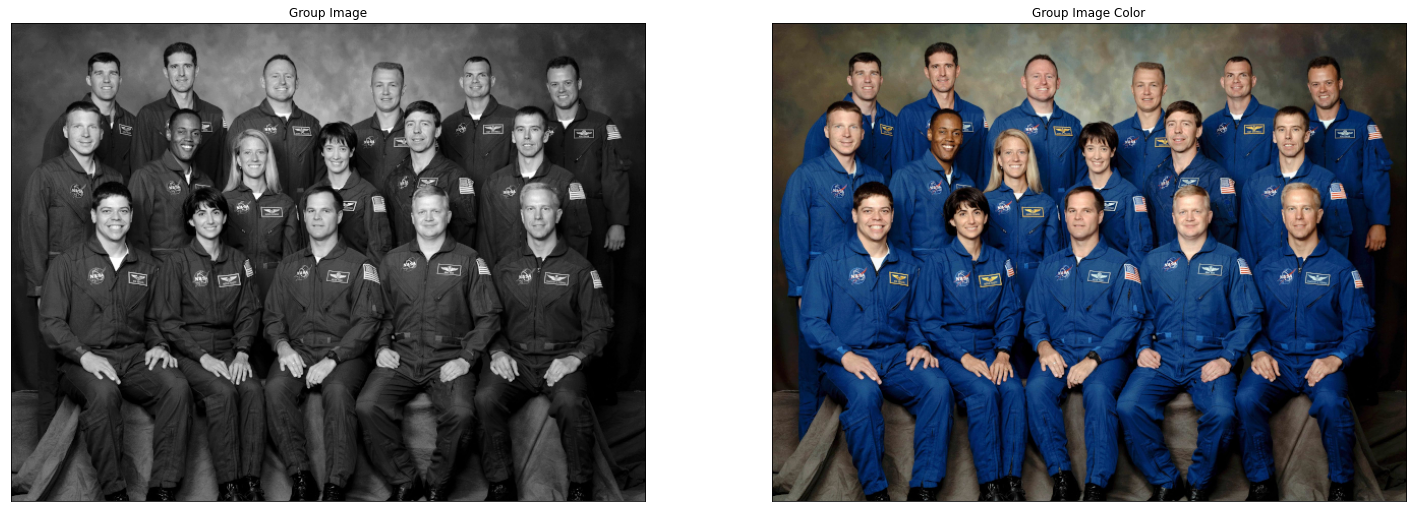

In [16]:
group_image_path = path + 'group_image.jpg'
group_image = cv2.imread(group_image_path, cv2.IMREAD_GRAYSCALE)

group_image_color = cv2.imread(group_image_path)
group_image_color = cv2.cvtColor(group_image_color, cv2.COLOR_BGR2RGB)

# Plot the Group Image
plot.figure(figsize = (25, 25)) 

plot.subplot(121)
plot.imshow(group_image, cmap='gray')
plot.title("Group Image")
plot.xticks([])
plot.yticks([])

plot.subplot(122)
plot.imshow(group_image_color)
plot.title("Group Image Color")
plot.xticks([])
plot.yticks([])

plot.show()

### Sliding windows with different thresholds

In [17]:
# Sliding window function
# Based on https://www.pyimagesearch.com/2015/03/23/sliding-windows-for-object-detection-with-python-and-opencv/
# A window of a defined size will slide over the image using width and height
def sliding_window(image, step, window_width, window_height):
  for height in range(0, image.shape[0], step):
    for width in range(0, image.shape[1], step):
      window = image[height: height + window_height, width: width + window_width]
      window = cv2.resize(window,(128, 192))
      yield(width, height, window)

# Face detection function
# Based on https://sandipanweb.wordpress.com/2018/01/06/eigenfaces-and-a-simple-face-detector-with-pca-svd-in-python/
def face_detection(image, mean, eigenvectors_subset):
  phi = image.flatten() - mean
  phiHat= np.sum((eigenvectors_subset.transpose().dot(mean)).dot(eigenvectors_subset))
  ed = np.linalg.norm(phi - phiHat)
  return ed

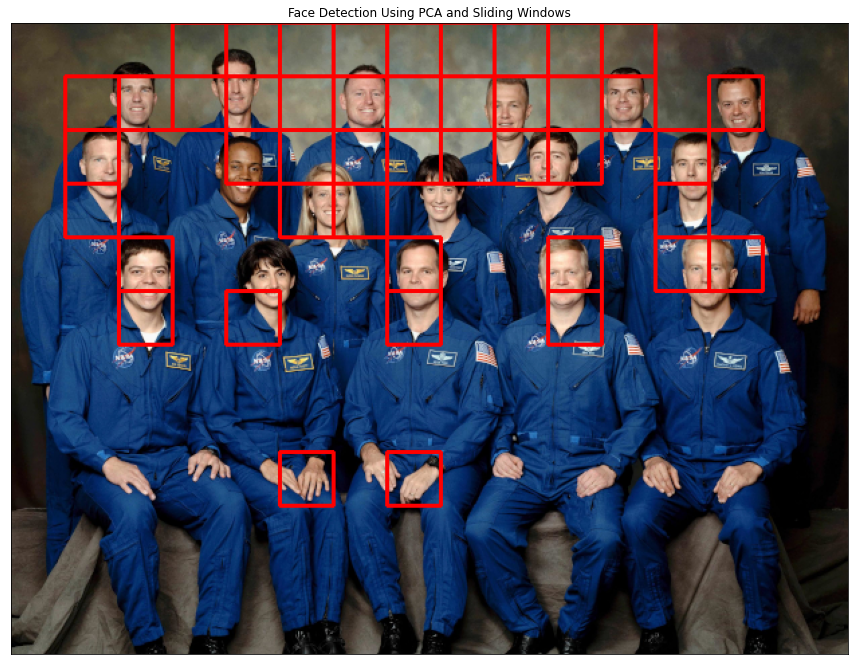

In [18]:
# Setup variables, these values were chosen after some tests to get the most efficient result
color = (255, 0, 0) #red
thickness = 2

step = 40
window_width = 40
window_height = 40
threshold = 1283600
# Get the k eigenfaces, with k = 100 set earlier
eigenvectors_subset = eigenvectors [:, 0: k]
mean = np.mean(vector_database.flatten(), axis = 0)

group_image_color_sliding_windows = group_image_color.copy()

for (width, height, window) in (sliding_window(group_image, step, window_width, window_height)):
  normal = face_detection(window, mean, eigenvectors_subset)
  if normal < threshold:
    # Draw a rectangle around the faces https://realpython.com/face-recognition-with-python/
    group_image_color_sliding_windows  = cv2.rectangle(group_image_color_sliding_windows, (width, height), (width + window_width, height + window_height), color, thickness)

# Display resulting image
plot.figure(figsize = (15, 15)) 

plot.imshow(group_image_color_sliding_windows)
plot.title("Face Detection Using PCA and Sliding Windows")
plot.xticks(())
plot.yticks(())
plot.show()

### Viola-Jones face detector

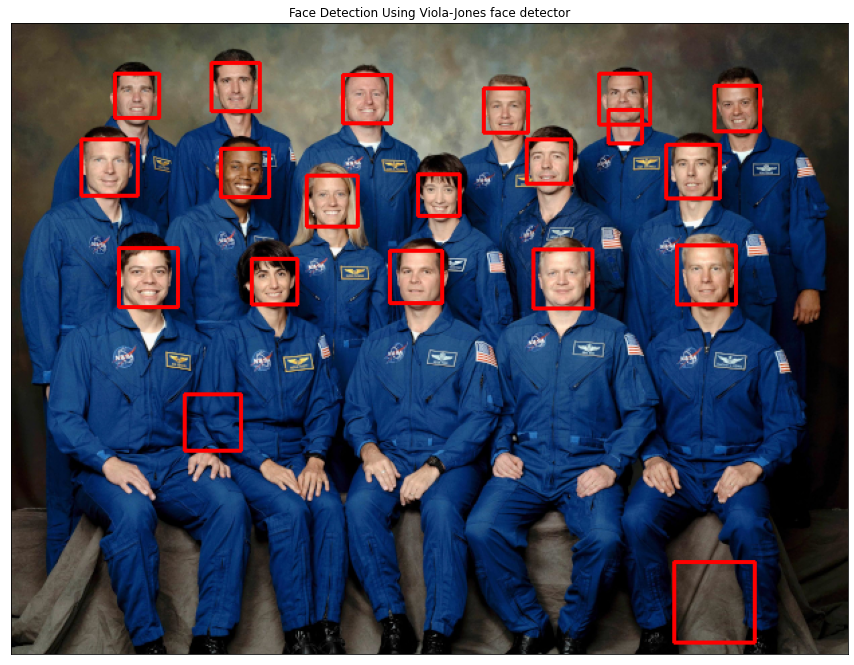

In [19]:
group_image_viola_jones = group_image_color.copy()

# Based on Tutorial 5
face_cascade = cv2.CascadeClassifier(path + 'haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(group_image, 1.1, 2)

for (x, y, width, height) in faces:
  group_image_viola_jones = cv2.rectangle(group_image_viola_jones, (x, y), (x + width, y + height), color, thickness)

# Plot the Group Image with Face Detection
plot.figure(figsize = (15, 15)) 

plot.imshow(group_image_viola_jones)
plot.title("Face Detection Using Viola-Jones face detector")
plot.xticks(())
plot.yticks(())
plot.show()

### Under what conditions would you expect the Viola-Jones detector to work when PCA does not?

Following the Viola-Jones face detector algorithm, we can observe 20 red boxes:
- 17 true positives
- 3 false positives 
- 0 false negative

Following the Sliding Windows and PCA face detector algorithm, we can observe 45 boxes:
- 33 true positives since it detects images containing different parts of a face
- 11 false positives
- 1 false negative, since it does not really detect the face of the woman in the middle of the image

Following these results, Viola-Jones face detector is way more efficient and effective than the PCA face detector.

<br/>
The Viola-Jones detector would work when there are faces really close to each other or if a face is hiding another face, or when a face is not entirely visible on a image, while PCA would not.
This is due to the fact that PCA compares each image with a database of eigenvectors and the training set might not be large enough to detect all of the faces. 
In addition, Viola-Jones detectors follow 2 important properties: 
- the eye region is darker than the upper-cheeks
- the nose bridge regio is brighter than the eyes
Therefore, elements such as light, face orientation, facial expressions etc have less impact when using the Viola-Jones detector, which makes it a really good face detector.